In [1]:
library(modelr)
library(tidyverse)
library(lubridate)
theme_set(theme_minimal())
options(repr.plot.width=6, repr.plot.height=4)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.3.0
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()
Warning message:
“package ‘lubridate’ was built under R version 3.4.4”
Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



# Lecture 20: Model building and comparison

In this lecture we'll look at:
- [Building models](http://r4ds.had.co.nz/model-building.html)
- How to compare [many models](http://r4ds.had.co.nz/many-models.html)
- Regressions with binary outcomes ([logistic regression](#Logistic-regression))

# Building models
In practice we progressively build up models until we feel like it has captured most of the patterns in the data.

Earlier in the course we studied the `diamonds` data set. We found that there was an unexpected relationship between cut, clarity, and price:

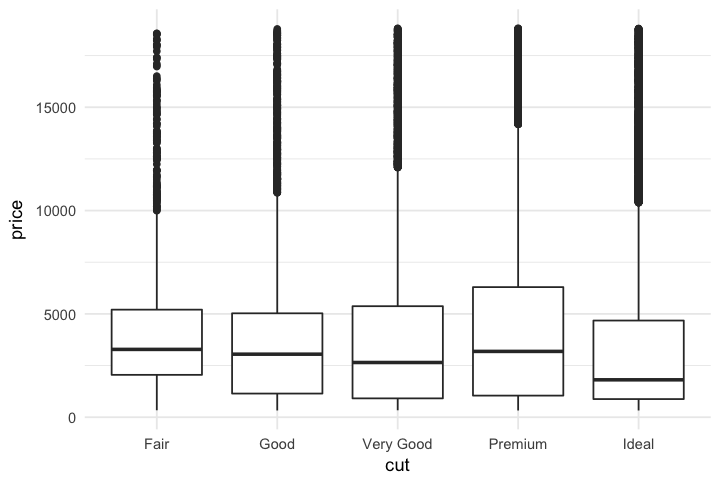

In [2]:
ggplot(diamonds, aes(cut, price)) + geom_boxplot()

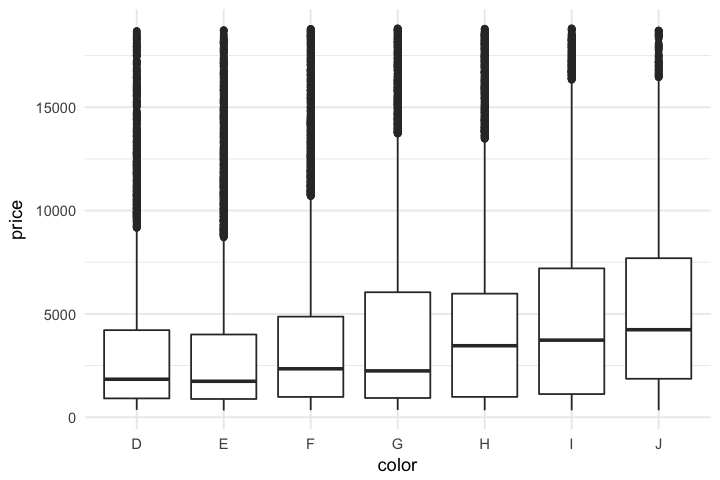

In [3]:
ggplot(diamonds, aes(color, price)) + geom_boxplot()

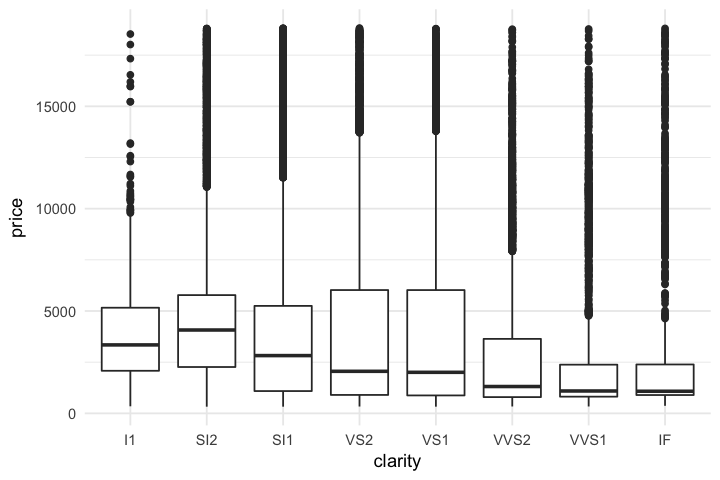

In [4]:
ggplot(diamonds, aes(clarity, price)) + geom_boxplot()

Surprisingly, there is a clear negative association between quality and price: higher quality diamonds seem to have a lower price. We reasoned that this is because of a confounder: the weight of the diamond is the single most important factor for determining the price of the diamond, and lower quality diamonds tend to be larger.

A plot of carat vs. price confirms this:

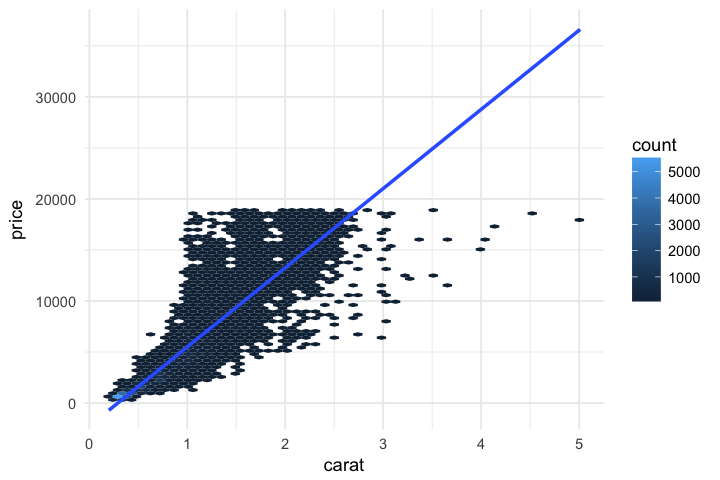

In [31]:
ggplot(diamonds, aes(carat, price)) + 
  geom_hex(bins = 50) + geom_smooth(method="lm")

We argued that log-transforming the data makes the relationship approximately linear. Also, we are going to drop the upper ~0.3% of heaviest diamonds by restricting to `carat < 2.5`:

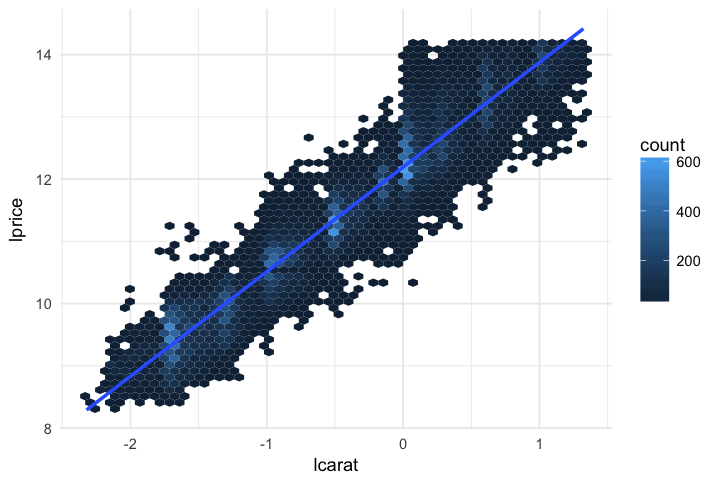

In [32]:
diamonds2 = diamonds %>% filter(carat <= 2.5) %>% 
                         mutate(lprice = log2(price), lcarat = log2(carat))
ggplot(diamonds2, aes(lcarat, lprice)) + geom_hex(bins = 50) + geom_smooth(method="lm")

Now the data are in good shape to fit a linear model:

In [7]:
mod_diamond = lm(lprice ~ lcarat, data = diamonds2)
summary(mod_diamond)


Call:
lm(formula = lprice ~ lcarat, data = diamonds2)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.96407 -0.24549 -0.00844  0.23930  1.93486 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 12.193863   0.001969  6194.5   <2e-16 ***
lcarat       1.681371   0.001936   868.5   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3767 on 53812 degrees of freedom
Multiple R-squared:  0.9334,	Adjusted R-squared:  0.9334 
F-statistic: 7.542e+05 on 1 and 53812 DF,  p-value: < 2.2e-16


In the original, untransformed space we get:

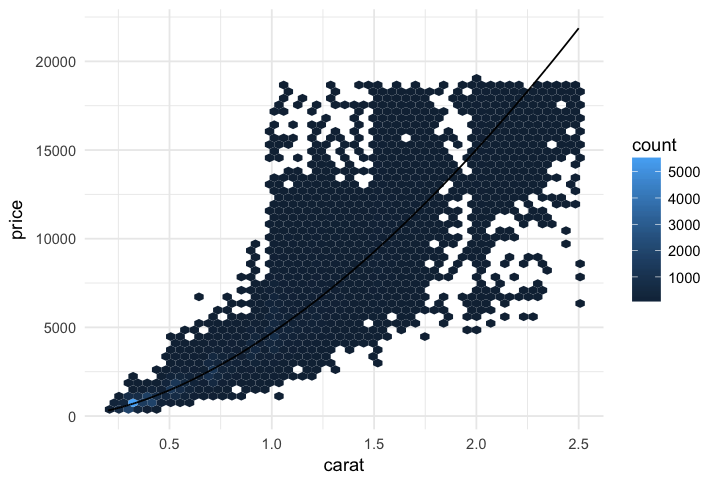

In [8]:
add_predictions(diamonds2, mod_diamond) %>% ggplot(aes(carat, price)) + 
    geom_hex(bins = 50) + geom_line(aes(y = 2 ** pred), colour = "black")

For large diamonds (`carat` > 2, say) there are many more observations *below* the regression line than above it. So the model predicts much higher prices for the large diamonds than are actually observed.

Turning to the residuals, we see that they look largely random, with no remaining discernible patterns. 

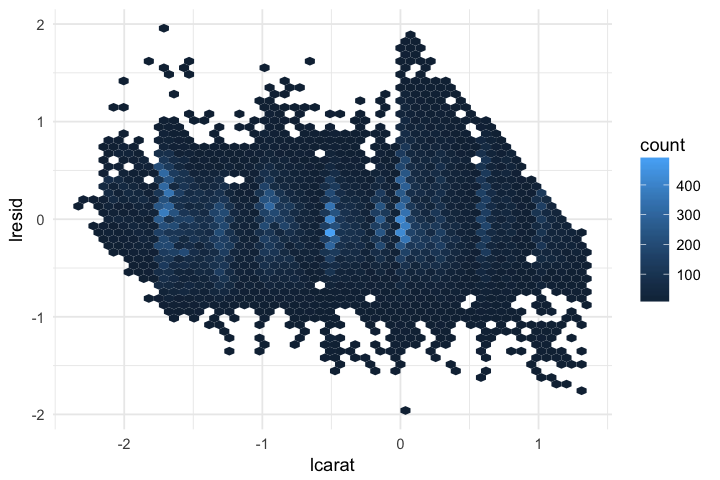

In [34]:
diamonds2 = diamonds2 %>% add_residuals(mod_diamond, "lresid")
ggplot(diamonds2, aes(lcarat, lresid)) + geom_hex(bins = 50)

The residuals represent the component of price that is not explained by the size of the diamond. We expect that this has something to do with the diamonds *quality*. To confirm this, we can repeat the same plots as above, this time using the residual in place of the price itself:

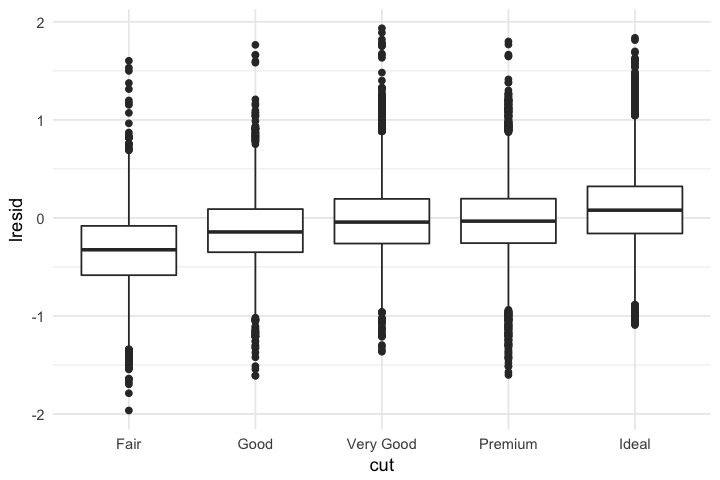

In [10]:
ggplot(diamonds2, aes(cut, lresid)) + geom_boxplot()

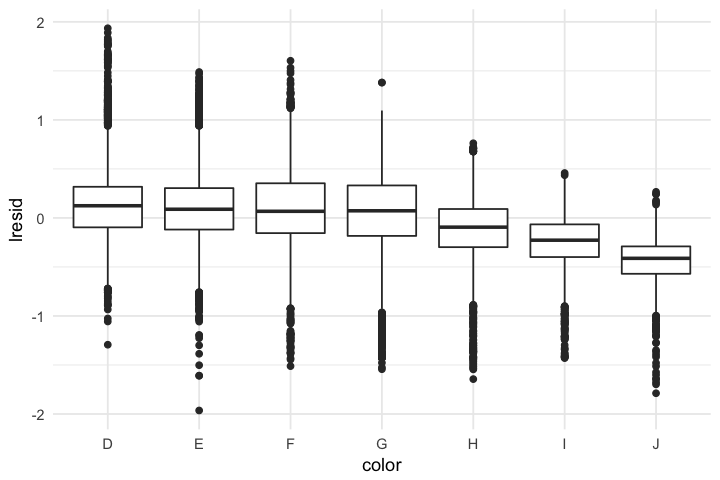

In [11]:
ggplot(diamonds2, aes(color, lresid)) + geom_boxplot()

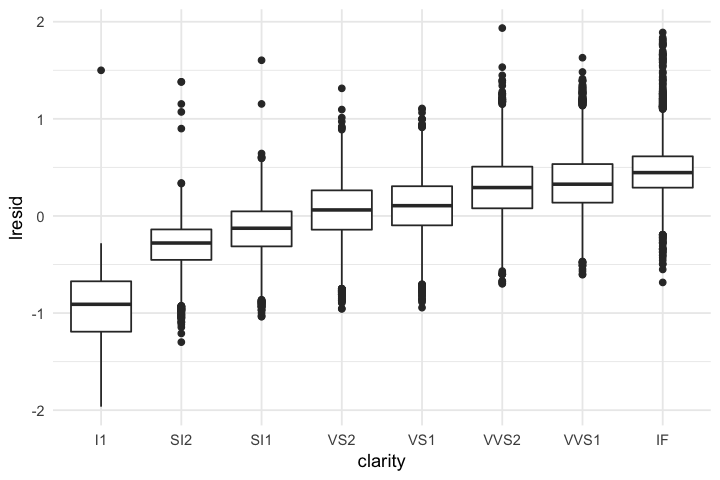

In [12]:
ggplot(diamonds2, aes(clarity, lresid)) + geom_boxplot()

These plots indicate the relationship that we would expect: Now we see the relationship we expect: as the quality of the diamond increases, so does its price.

Given that the residuals still contain obvious patterns, we could go ahead and build up a more complex model which includes these additional attributes as predictors:

In [13]:
mod_diamond2 = lm(lprice ~ lcarat + cut + color + clarity, data = diamonds2)
summary(mod_diamond2)


Call:
lm(formula = lprice ~ lcarat + cut + color + clarity, data = diamonds2)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.17388 -0.12437 -0.00094  0.11920  2.78322 

Coefficients:
             Estimate Std. Error  t value Pr(>|t|)    
(Intercept) 12.206978   0.001693 7211.806  < 2e-16 ***
lcarat       1.886239   0.001124 1677.809  < 2e-16 ***
cut.L        0.173866   0.003386   51.349  < 2e-16 ***
cut.Q       -0.050346   0.002980  -16.897  < 2e-16 ***
cut.C        0.019129   0.002583    7.407 1.31e-13 ***
cut^4       -0.002410   0.002066   -1.166    0.243    
color.L     -0.633998   0.002910 -217.872  < 2e-16 ***
color.Q     -0.137580   0.002676  -51.409  < 2e-16 ***
color.C     -0.022072   0.002503   -8.819  < 2e-16 ***
color^4      0.016570   0.002297    7.213 5.54e-13 ***
color^5     -0.002828   0.002169   -1.304    0.192    
color^6      0.003533   0.001971    1.793    0.073 .  
clarity.L    1.308155   0.005179  252.598  < 2e-16 ***
clarity.Q   -0.334090   0.004839

Now to generate predictions we are required to specify four pieces of information: the (log) weight, color, cut and clarity. To examine the relationship between the prediction and one of these variables, it helps to set the remaining variables to their "typical" values (something like the median in the case of a continuous variable, or mode in the case of a discrete variable.)

In [14]:
grid = diamonds2 %>% data_grid(cut, lcarat = -0.515, color = "G", clarity = "SI1") %>%
                     add_predictions(mod_diamond2) %>% print

# A tibble: 5 x 5
  cut       lcarat color clarity  pred
  <ord>      <dbl> <chr> <chr>   <dbl>
1 Fair      -0.515 G     SI1      11.0
2 Good      -0.515 G     SI1      11.1
3 Very Good -0.515 G     SI1      11.2
4 Premium   -0.515 G     SI1      11.2
5 Ideal     -0.515 G     SI1      11.2


For typical values of the remaining predictors, we see the expected relationship between cut and the predicted
log price:

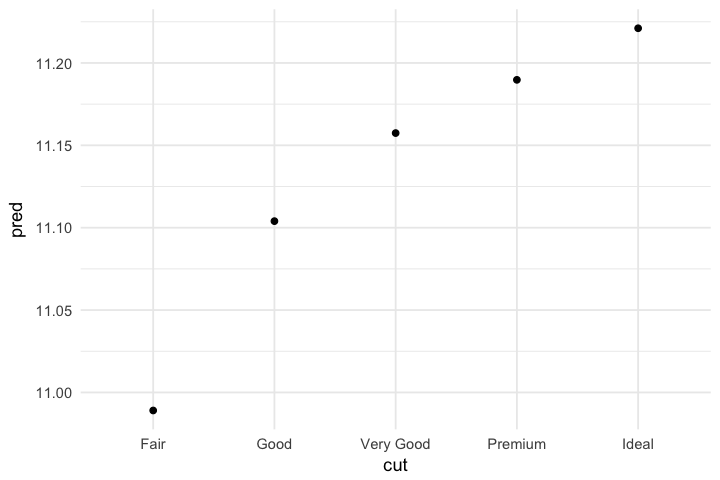

In [15]:
ggplot(grid, aes(cut, pred)) + geom_point()

## Factors affecting flights
Let's try building up a model that explains the number of flights leaving from NYC airports each day.

In [16]:
library(nycflights13)
daily = flights %>% mutate(date = make_date(year, month, day)) %>% count(date) %>% print

# A tibble: 365 x 2
   date           n
   <date>     <int>
 1 2013-01-01   842
 2 2013-01-02   943
 3 2013-01-03   914
 4 2013-01-04   915
 5 2013-01-05   720
 6 2013-01-06   832
 7 2013-01-07   933
 8 2013-01-08   899
 9 2013-01-09   902
10 2013-01-10   932
# ... with 355 more rows


As we have already seen, there is a strong daily component to flights, as well as weaker monthly and seasonal effects:

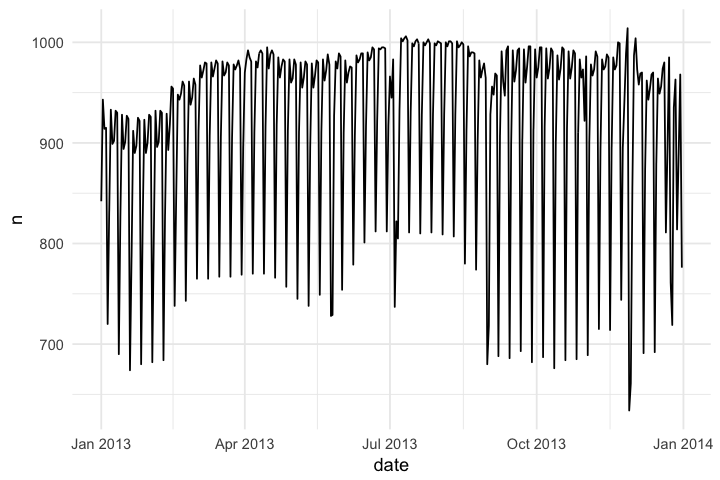

In [17]:
ggplot(daily, aes(x = date, y = n)) + geom_line()

The most obvious pattern is a day-of-the-week effect. For example:

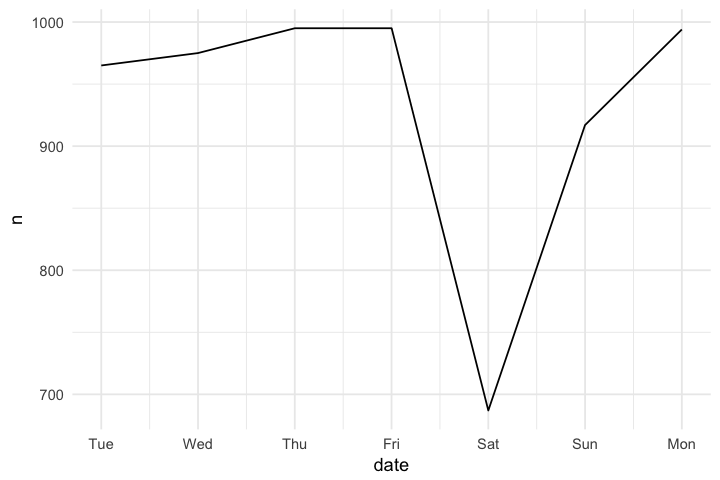

In [37]:
daily %>% filter(week(date) == 40) %>% ggplot(aes(x = date, y = n)) + 
    geom_line() + scale_x_date(date_labels = "%a", date_breaks = "1 day")

Another way to see this:

# A tibble: 365 x 3
   date           n wday 
   <date>     <int> <ord>
 1 2013-01-01   842 Tue  
 2 2013-01-02   943 Wed  
 3 2013-01-03   914 Thu  
 4 2013-01-04   915 Fri  
 5 2013-01-05   720 Sat  
 6 2013-01-06   832 Sun  
 7 2013-01-07   933 Mon  
 8 2013-01-08   899 Tue  
 9 2013-01-09   902 Wed  
10 2013-01-10   932 Thu  
# ... with 355 more rows


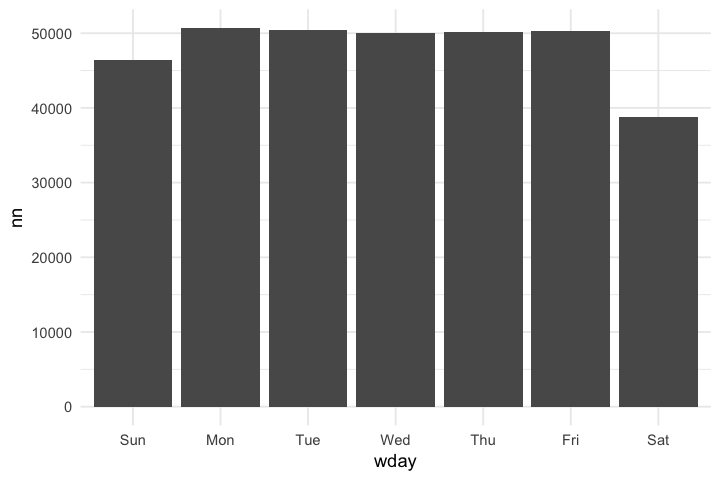

In [19]:
daily = daily %>% mutate(wday = wday(date, label = T)) %>% print
daily %>% count(wday, wt = n) %>% ggplot(aes(x = wday, y = nn)) + geom_col()

So, let's first regress out the weekday effect:

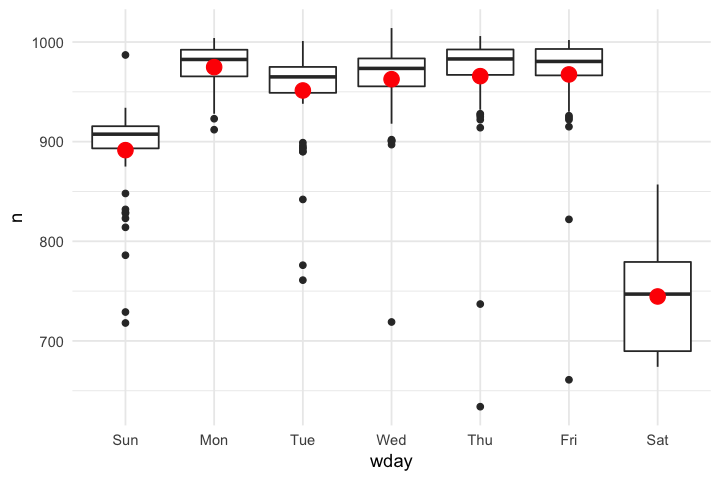

In [50]:
mod = lm(n ~ wday, data = daily) 

grid = daily %>% data_grid(wday) %>% add_predictions(mod, "n")

ggplot(daily, aes(wday, n)) + 
  geom_boxplot() +
  geom_point(data = grid, colour = "red", size = 4)

Having removed the day-of-week effect, let's now re-examine the residuals:

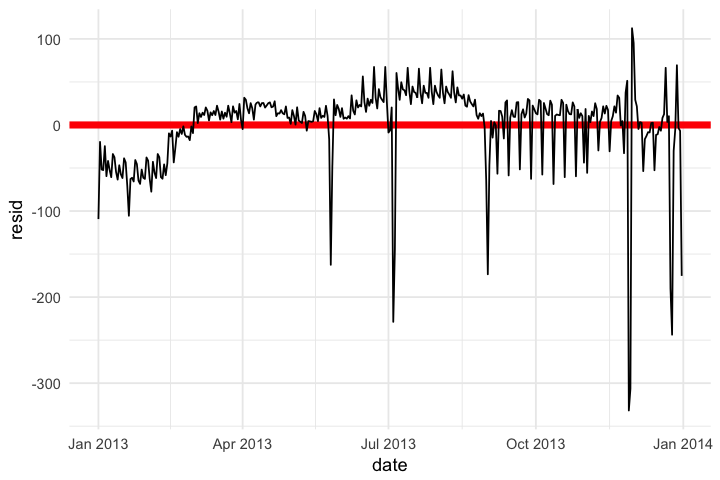

In [51]:
daily = daily %>% add_residuals(mod)
daily %>% ggplot(aes(date, resid)) + geom_ref_line(h = 0, colour = "red") + geom_line()

The $y$-axis now plots the deviation from the expected number of flights given the day of the week. This looks better but we still see quite a bit of structure in the data. Starting around June the model starts doing worse. In particular, there seems to be certain days that are extreme outliers, as indicated by the spikes. Let's see if we can figure out what those represent:

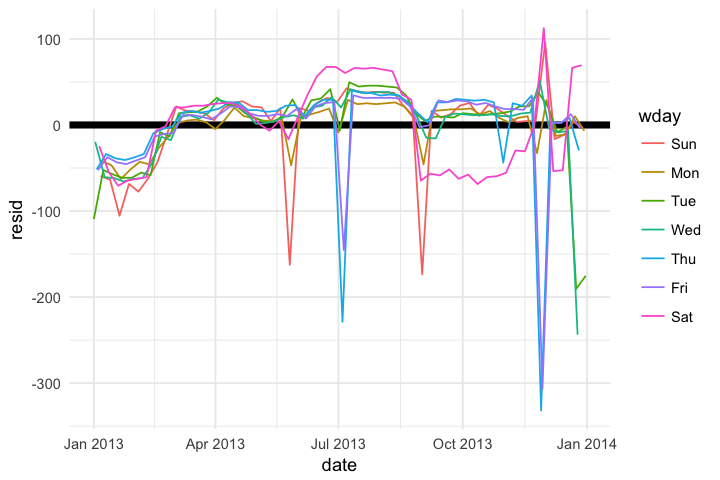

In [22]:
daily %>% ggplot(aes(date, resid, colour = wday)) + 
    geom_ref_line(h = 0, colour = "black") + geom_line()

Additionally, we have certain days with many fewer flights than expected:

In [23]:
daily %>% filter(resid < -100)

   date       n   wday resid    
1  2013-01-01 842 Tue  -109.3585
2  2013-01-20 786 Sun  -105.4808
3  2013-05-26 729 Sun  -162.4808
4  2013-07-04 737 Thu  -228.7500
5  2013-07-05 822 Fri  -145.4615
6  2013-09-01 718 Sun  -173.4808
7  2013-11-28 634 Thu  -331.7500
8  2013-11-29 661 Fri  -306.4615
9  2013-12-24 761 Tue  -190.3585
10 2013-12-25 719 Wed  -243.6923
11 2013-12-31 776 Tue  -175.3585

We recognize many of these as public holidays: New Year's, Thanksgiving, Christmas.

More generally, there is a seasonal trend whereby there are fewer daily flights than expected early and later in the year, and more than expected in the summer months:

`geom_smooth()` using method = 'loess'


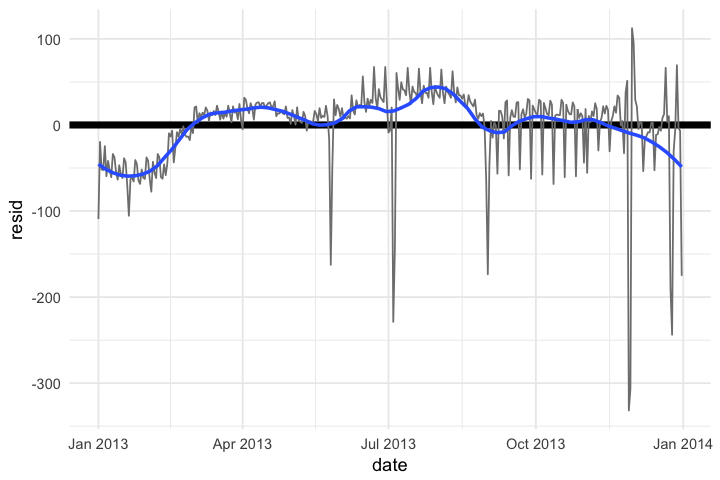

In [55]:
daily %>% ggplot(aes(date, resid)) + geom_ref_line(h = 0, colour = "black") + 
  geom_line(colour = "grey50") + 
  geom_smooth(se = FALSE, span = 0.20)

### Saturday effect
First we focus on capturing the "Saturday" effect. If we just look at Saturdays, we see that:

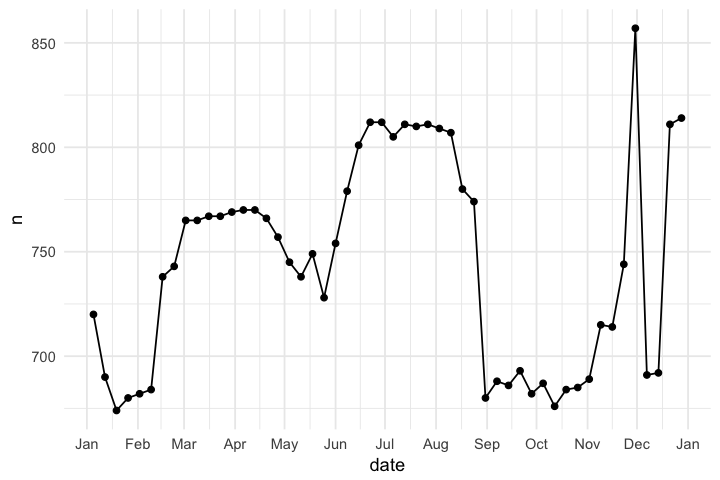

In [25]:
daily %>% filter(wday == "Sat") %>%  ggplot(aes(date, n)) + 
    geom_point() +  geom_line() + scale_x_date(date_breaks = "1 month", date_labels = "%b")

Let's try first to manually break this up into regions of approximately equal effect.

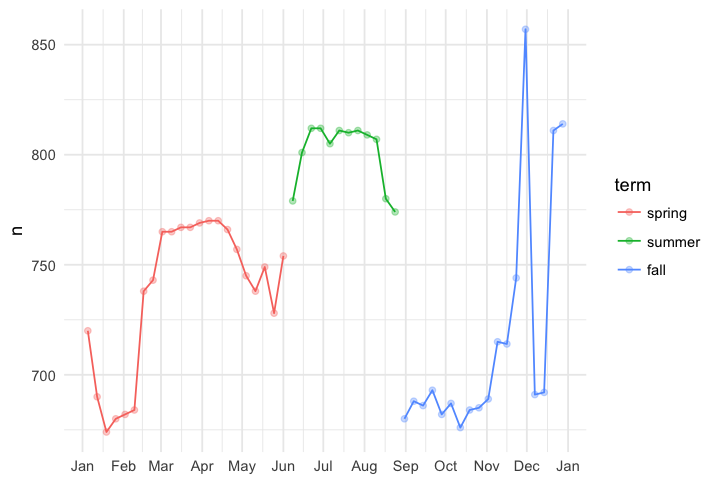

In [26]:
term <- function(date) {
  cut(date, 
    breaks = ymd(20130101, 20130605, 20130825, 20140101),
    labels = c("spring", "summer", "fall") 
  )
}

daily <- daily %>% 
  mutate(term = term(date)) 

daily %>% 
  filter(wday == "Sat") %>% 
  ggplot(aes(date, n, colour = term)) +
  geom_point(alpha = 1/3) + 
  geom_line() +
  scale_x_date(NULL, date_breaks = "1 month", date_labels = "%b")

Now we can compare how adding in this term effect changes our model fit:

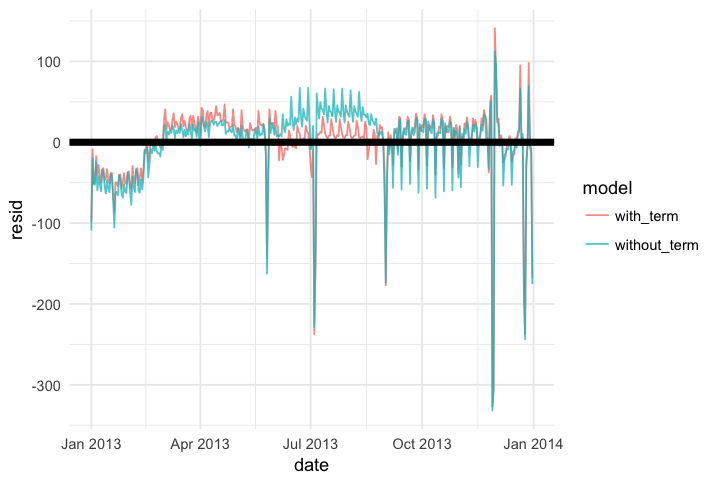

In [27]:
mod1 = lm(n ~ wday, data = daily)
mod2 = lm(n ~ wday * term, data = daily)

daily %>% gather_residuals(without_term = mod1, with_term = mod2) %>% 
  ggplot(aes(date, resid, colour = model)) + geom_line(alpha = 0.75) +
  geom_ref_line(h = 0, colour = "black") 

The fit looks better in the sense that the `with_term` line hews more closely to the reference line `resid=0`. But there are still a lot of big outliers that the model does not account for.

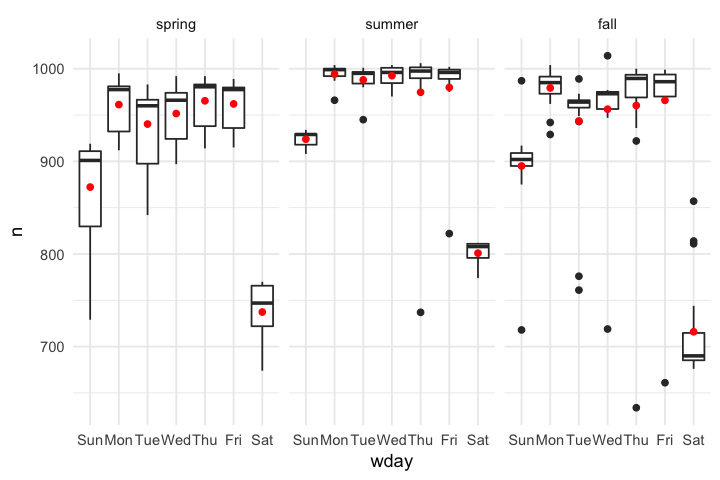

In [28]:
grid = daily %>% data_grid(wday, term) %>% add_predictions(mod2, "n")
ggplot(daily, aes(wday, n)) + geom_boxplot() + 
  geom_point(data = grid, colour = "red") + facet_wrap(~ term)

The red dots here represent the model predictions. Note the effect of the outliers (black dots) on the model predictions: they tend to drag the predictions towards them. This is especially evident in the fall months. This is another example of how the linear model can be susceptible to outliers. To counteract this, we can use a model that is more robust to outliers:

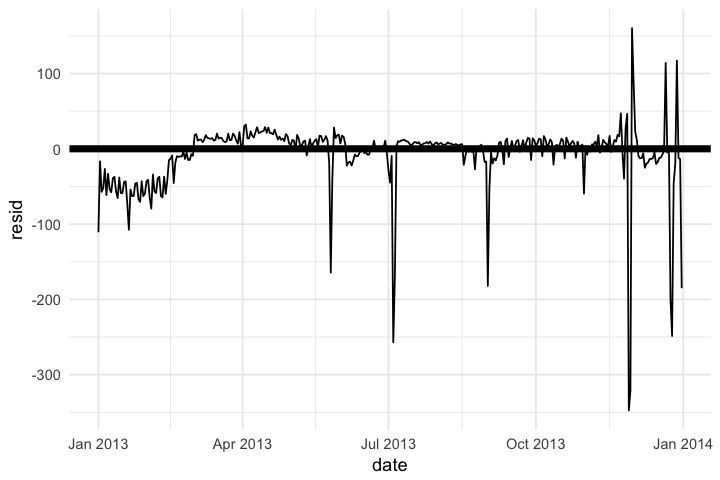

In [29]:
mod3 = MASS::rlm(n ~ wday * term, data = daily)
daily %>% add_residuals(mod3, "resid") %>% 
  ggplot(aes(date, re sid)) + 
  geom_ref_line(h = 0, colour = "black") +
  geom_line()

This is looking much better. Except for a small winter effect, plus some outlying days in the summer and fall, the model now fits pretty well.

Lastly, we can go beyond the linear model and fit other types of models to these data:

In [30]:
mod4 = gam::gam(n ~ wday * term + s(date), data = daily)
summary(mod4)
daily %>% add_residuals(mod4, "resid") %>% 
  ggplot(aes(date, resid)) + 
  geom_ref_line(h = 0, colour = "black") +
  geom_line()

ERROR: Error in loadNamespace(name): there is no package called ‘gam’


## Logistic regression
In all of the regressions we have seen so far, the dependent ($y$) variable has been continuous: life expectancy, price, etc. However, there are many situations where the outcome is categorical. For simplicity, we will assume it's binary, and can be coded as 0/1. How should we model binary data?

One idea is to just stick what we know and use the linear model. Will this work?

In [56]:
mdl <- lm(I(price > 1000) ~ carat, data = diamonds)
summary(mdl)


Call:
lm(formula = I(price > 1000) ~ carat, data = diamonds)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0679 -0.4545  0.1183  0.3181  0.5733 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.287986   0.003011   95.63   <2e-16 ***
carat       0.554868   0.003245  171.01   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3572 on 53938 degrees of freedom
Multiple R-squared:  0.3516,	Adjusted R-squared:  0.3516 
F-statistic: 2.924e+04 on 1 and 53938 DF,  p-value: < 2.2e-16


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


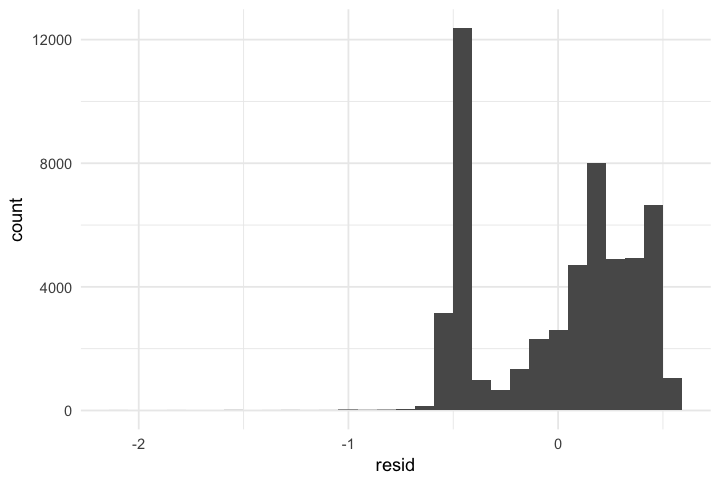

In [57]:
diamonds %>% add_residuals(mdl) %>% mutate(resid=as.numeric(resid)) %>% 
     ggplot + geom_histogram(aes(x=resid))

The linear model is fundamentally wrong for categorical outcomes, because the normal distribution is not discrete. (Note that categorical covariates are fine.) 

The linear model says:

$$y = f(a + b x)$$ 

for $f(x)=x$. For 0/1 outcomes, let's instead try to think probabilistically:

$$\text{Prob}(y=1) = \underbrace{f(a + b x)}_{(\text{some function of the covariates})}$$

What criteria should this function $f$ have?
- It's range needs to be $[0,1]$.
- For "extreme" values of $a + bx$ it should tend to zero one one.

The function we will use, for various technical reasons, is called the **logistic function**:
$$f(x) = \frac{1}{1 + e^{-x}}.$$

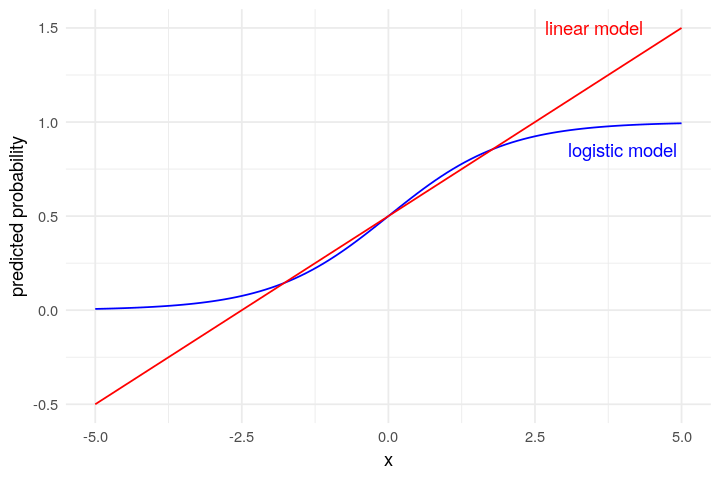

In [ ]:
expand.grid(x=seq(-5, 5, .1)) %>% ggplot(aes(x=x)) + 
    stat_function(fun=function(x) (1 / (1 + exp(-x))), xlim=c(-5, 5), color="blue") +
    stat_function(fun=function(x) 1/2 + x/5, xlim=c(-5, 5), color="red") +
    annotate(x=3.5, y=1.5, geom="text", label="linear model", color="red") +
    annotate(x=4.0, y=.85, geom="text", label="logistic model", color="blue") + 
    ylab("predicted probability")

Let's re-do our model fitting and residual diagnostics using this model:

In [58]:
mdl <- glm(I(price > 10000) ~ carat, data=diamonds, family="binomial")
summary(mdl)


Call:
glm(formula = I(price > 10000) ~ carat, family = "binomial", 
    data = diamonds)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.6303  -0.2201  -0.0459  -0.0217   2.7322  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -10.5461     0.1250  -84.37   <2e-16 ***
carat         6.8379     0.0882   77.53   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 34308  on 53939  degrees of freedom
Residual deviance: 12308  on 53938  degrees of freedom
AIC: 12312

Number of Fisher Scoring iterations: 8


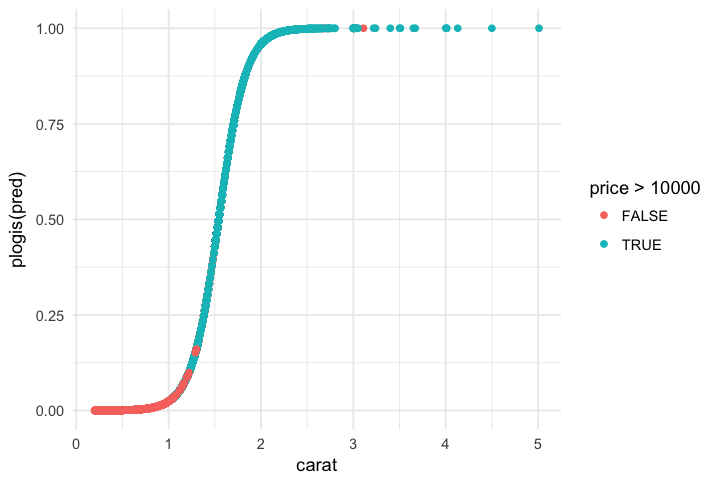

In [59]:
diamonds %>% add_predictions(mdl) %>% ggplot + geom_point(aes(x=carat, y=plogis(pred), 
                                                              color=price > 10000))

### Example: Image classification
We will use logistic regression to build an image classifier. We will train a model that recognizes the number 5.

The `mnist` table is a data frame with 60000 observations and 785 columns. Each row corresponds to a handwritten digit. The first column is the label of that image, and the next $784=28^2$ columns are pixel data for each image. 

# A tibble: 1 x 785
     X1    X2    X3    X4    X5    X6    X7    X8    X9   X10   X11   X12   X13
  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1     5     0     0     0     0     0     0     0     0     0     0     0     0
# ... with 772 more variables: X14 <dbl>, X15 <dbl>, X16 <dbl>, X17 <dbl>,
#   X18 <dbl>, X19 <dbl>, X20 <dbl>, X21 <dbl>, X22 <dbl>, X23 <dbl>,
#   X24 <dbl>, X25 <dbl>, X26 <dbl>, X27 <dbl>, X28 <dbl>, X29 <dbl>,
#   X30 <dbl>, X31 <dbl>, X32 <dbl>, X33 <dbl>, X34 <dbl>, X35 <dbl>,
#   X36 <dbl>, X37 <dbl>, X38 <dbl>, X39 <dbl>, X40 <dbl>, X41 <dbl>,
#   X42 <dbl>, X43 <dbl>, X44 <dbl>, X45 <dbl>, X46 <dbl>, X47 <dbl>,
#   X48 <dbl>, X49 <dbl>, X50 <dbl>, X51 <dbl>, X52 <dbl>, X53 <dbl>,
#   X54 <dbl>, X55 <dbl>, X56 <dbl>, X57 <dbl>, X58 <dbl>, X59 <dbl>,
#   X60 <dbl>, X61 <dbl>, X62 <dbl>, X63 <dbl>, X64 <dbl>, X65 <dbl>,
#   X66 <dbl>, X67 <dbl>, X68 <dbl>, X69 <dbl>, X70 <dbl>, X71 <dbl>,
#   X72 <dbl>, X73 <dbl>, X74 <dbl>

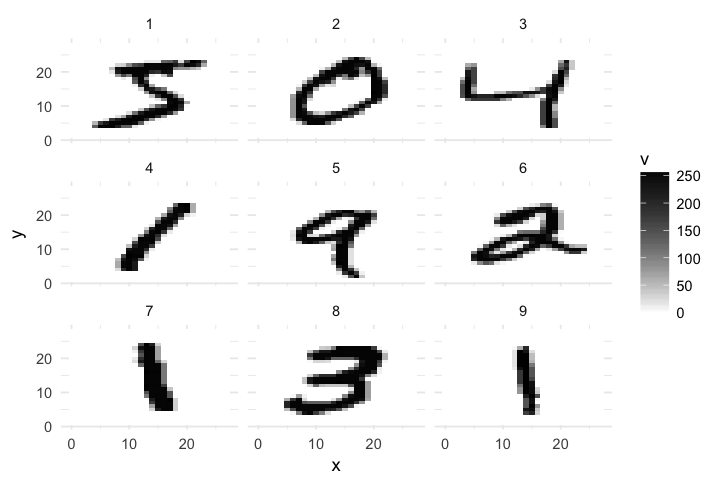

In [65]:
mnist %>% slice(1) %>% print
mnist %>% slice(1:9) %>% mutate(i=row_number()) %>% 
    gather("k", "v", X2:X785) %>% mutate(px = as.numeric(str_sub(k, 2)) - 2,
                                         x = px %% 28,
                                         y = 28 - (px %/% 28)) %>% 
    ggplot() + geom_tile(aes(x=x, y=y, fill=v)) + facet_wrap(~ i) + 
    scale_fill_gradient(low="white", high="black")

### Challenge problem
Use logistic regression to build an image classifier that tells whether or not the image is a "5".

In [67]:
train <- slice(mnist, 1:50000)
test <- slice(mnist, -(1:50000))

ERROR: Error in eval(lhs, parent, parent): object 'classifier' not found
